Fonte: https://ieee-dataport.org/documents/twitter-dataset-mental-disorders-detection

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import emoji
import re
import os

In [3]:
# Caminho da pasta principal
# data_dir = "Timelines/English"
# output_file = "tweets_english.csv"

# all_data = []

# # Percorre cada subpasta de categoria
# for category in os.listdir(data_dir):
#     category_path = os.path.join(data_dir, category)
#     if os.path.isdir(category_path):
#         label = category.replace("_eng", "")  # Remove sufixo _eng

#         # Percorre cada CSV (um por usuário)
#         for filename in os.listdir(category_path):
#             file_path = os.path.join(category_path, filename)
#             if filename.endswith(".csv"):
#                 try:
#                     df = pd.read_csv(file_path)
#                     if 'tweet' in df.columns:
#                         tweets = df['tweet'].dropna().astype(str).tolist()
#                         all_data.extend([{"text": t, "label": label} for t in tweets])
#                 except Exception as e:
#                     print(f"Erro ao ler {file_path}: {e}")

# # Cria DataFrame e salva
# df_all = pd.DataFrame(all_data)
# # df_all.to_csv(output_file, index=False)
# print(f"Arquivo salvo: {output_file} ({len(df_all)} linhas)")


In [4]:
# Carrega o CSV
df = pd.read_csv("tweets_english.csv")

# Conta o número de tweets por classe
tweet_counts = df['label'].value_counts()

# Mostra os resultados
print("Número de tweets por classe:")
print(df['label'].value_counts())

Número de tweets por classe:
label
Control          2761555
Adhd             1009002
Depression        336997
Asd               273435
Bipolar           200425
Anxiety           195944
Ptsd              195519
Ocd               119545
Schizophrenia      40178
Eating             37893
Name: count, dtype: int64


In [5]:
# Mantém apenas ADHD e control
# df_binary = df[df['label'].isin(['Adhd', 'Control'])].copy()

# print("Número de tweets por classe (ADHD vs Control):")
# print(df_binary['label'].value_counts())

# df_binary.to_csv("tweets_adhd_vs_control.csv", index=False)
# print("Arquivo salvo como tweets_adhd_vs_control.csv")

In [6]:
# Carrega o CSV
df = pd.read_csv("tweets_adhd_vs_control.csv")

# Conta o número de tweets por classe
tweet_counts = df['label'].value_counts()

# Mostra os resultados
print("Número de tweets por classe:")
print(df['label'].value_counts())

Número de tweets por classe:
label
Control    2761555
Adhd       1009002
Name: count, dtype: int64


In [7]:
df_balanced = df

# Cria uma nova coluna com a contagem de palavras
df_balanced['word_count'] = df_balanced['text'].apply(lambda x: len(x.split()))

# Filtra apenas tweets com pelo menos 4 palavras
df_balanced = df_balanced[df_balanced['word_count'] >= 4].copy()

print("Tweets restantes após remoção:")
print(df_balanced['label'].value_counts())

Tweets restantes após remoção:
label
Control    2579936
Adhd        950916
Name: count, dtype: int64


In [8]:
df_balanced = df_balanced.drop_duplicates(subset="text")

print("Tweets restantes após remoção:")
print(df_balanced['label'].value_counts())

Tweets restantes após remoção:
label
Control    2392769
Adhd        934865
Name: count, dtype: int64


In [9]:
df_control = df_balanced[df_balanced['label'] == 'Control']
df_adhd = df_balanced[df_balanced['label'] == 'Adhd']

df_control_downsampled = resample(df_control, 
                                  replace=False,     
                                  n_samples=len(df_adhd),  # mesmo número que adhd
                                  random_state=42)

df_balanced = pd.concat([df_control_downsampled, df_adhd])

print("Tweets restantes após remoção:")
print(df_balanced['label'].value_counts())

Tweets restantes após remoção:
label
Control    934865
Adhd       934865
Name: count, dtype: int64


In [10]:
def preprocess(text):
    # Remove URLs, menções, hashtags, RTs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)     # remove links
    text = re.sub(r'@\w+|\#', '', text)                     # remove menções e hashtags
    text = emoji.replace_emoji(text, replace='')            # remove emojis
    text = re.sub(r'[^a-zA-Z\s]', '', text)                 # remove pontuação e símbolos
    text = re.sub(r'\s+', ' ', text).strip()                # remove espaços extras
    return text.lower()

df_balanced['text'] = df_balanced['text'].astype(str).apply(preprocess)

In [11]:
# Uma linha aleatória da classe ADHD
print("Exemplo de tweet da classe ADHD:")
print(df_balanced[df_balanced['label'] == 'Adhd'][['text', 'label']].sample(1).iloc[0])

# Uma linha aleatória da classe Control
print("\nExemplo de tweet da classe Control:")
print(df_balanced[df_balanced['label'] == 'Control'][['text', 'label']].sample(1).iloc[0])


Exemplo de tweet da classe ADHD:
text     this is me exactly im taking that baby as far ...
label                                                 Adhd
Name: 982984, dtype: object

Exemplo de tweet da classe Control:
text     im impressed you should become famous in the m...
label                                              Control
Name: 2069465, dtype: object


In [12]:
# Mapeamento manual
label_map = {'Control': 0, 'Adhd': 1}
df_balanced['label'] = df_balanced['label'].map(label_map)

In [13]:
# Conta o número de tweets por classe
tweet_counts = df_balanced['label'].value_counts()

# Mostra os resultados
print("Número de tweets por classe:")
print(df_balanced['label'].value_counts())

Número de tweets por classe:
label
0    934865
1    934865
Name: count, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['text'], df_balanced['label'],
    test_size=0.2, random_state=42, stratify=df_balanced['label']
)

In [15]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

🔹 Naive Bayes
              precision    recall  f1-score   support

     control       0.67      0.53      0.59    186973
        adhd       0.61      0.73      0.67    186973

    accuracy                           0.63    373946
   macro avg       0.64      0.63      0.63    373946
weighted avg       0.64      0.63      0.63    373946

--------------------------------------------------


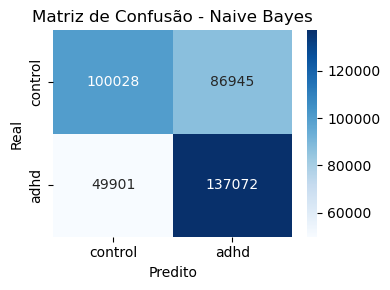

--------------------------------------------------
🔹 Logistic Regression
              precision    recall  f1-score   support

     control       0.66      0.61      0.63    186973
        adhd       0.64      0.68      0.66    186973

    accuracy                           0.65    373946
   macro avg       0.65      0.65      0.65    373946
weighted avg       0.65      0.65      0.65    373946

--------------------------------------------------


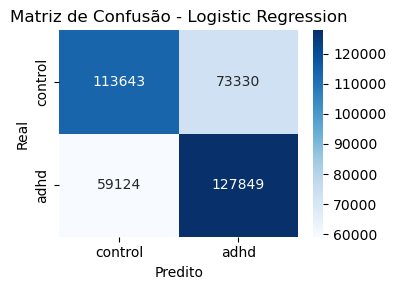

--------------------------------------------------
🔹 Linear SVM
              precision    recall  f1-score   support

     control       0.66      0.61      0.63    186973
        adhd       0.64      0.69      0.66    186973

    accuracy                           0.65    373946
   macro avg       0.65      0.65      0.65    373946
weighted avg       0.65      0.65      0.65    373946

--------------------------------------------------


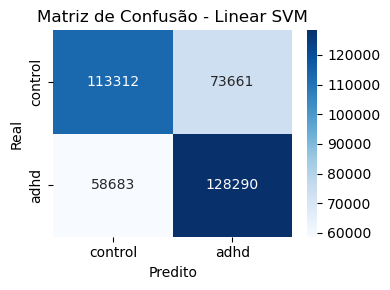

--------------------------------------------------
🔹 Decision Tree
              precision    recall  f1-score   support

     control       0.65      0.36      0.46    186973
        adhd       0.56      0.81      0.66    186973

    accuracy                           0.58    373946
   macro avg       0.60      0.58      0.56    373946
weighted avg       0.60      0.58      0.56    373946

--------------------------------------------------


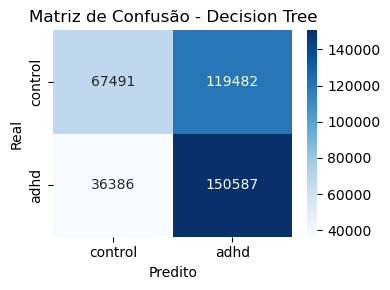

--------------------------------------------------
🔹 Random Forest
              precision    recall  f1-score   support

     control       0.60      0.63      0.61    186973
        adhd       0.61      0.57      0.59    186973

    accuracy                           0.60    373946
   macro avg       0.60      0.60      0.60    373946
weighted avg       0.60      0.60      0.60    373946

--------------------------------------------------


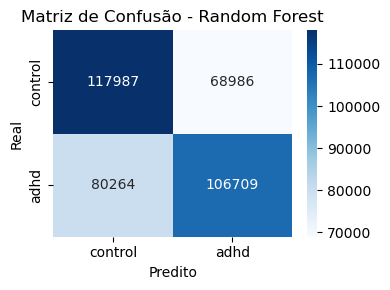

--------------------------------------------------
🔹 Gradient Boosting
              precision    recall  f1-score   support

     control       0.64      0.40      0.49    186973
        adhd       0.56      0.78      0.65    186973

    accuracy                           0.59    373946
   macro avg       0.60      0.59      0.57    373946
weighted avg       0.60      0.59      0.57    373946

--------------------------------------------------


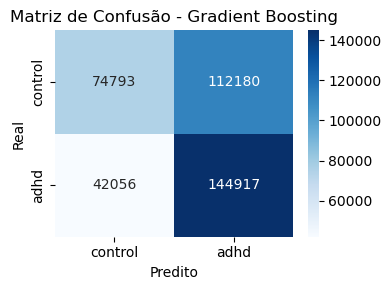

--------------------------------------------------

📊 Comparativo final:
                Modelo  Acurácia  F1-Score
0          Naive Bayes  0.634049  0.667033
2           Linear SVM  0.646088  0.659718
3        Decision Tree  0.583180  0.658964
1  Logistic Regression  0.645794  0.658757
5    Gradient Boosting  0.587545  0.652676
4        Random Forest  0.600878  0.588467


In [16]:
# Lista de modelos
models = {
    "Naive Bayes": MultinomialNB(alpha=0.5),
    
    "Logistic Regression": LogisticRegression(
        C=1.0,        # regularização média
        penalty='l2',
        solver='liblinear',
        max_iter=1000
    ),

    "Linear SVM": LinearSVC(
        C=1.0,
        dual='auto',  # evita o warning
        max_iter=5000,
        tol=1e-3
    ),

    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=20,               # evita árvores muito profundas
        min_samples_split=10,
        min_samples_leaf=5
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,               # boostings pequenos evitam overfitting
        subsample=0.8,             # amostragem estocástica
        random_state=42
    )
}

results = []

# Avaliação de cada modelo
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        "Modelo": name,
        "Acurácia": acc,
        "F1-Score": f1
    })
    print(f"🔹 {name}\n{classification_report(y_test, y_pred, target_names=['control', 'adhd'])}")
    print("-" * 50)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['control', 'adhd'],
                yticklabels=['control', 'adhd'])
    plt.title(f"Matriz de Confusão - {name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    print("-" * 50)

# Mostrar resumo
df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n📊 Comparativo final:")
print(df_results)

In [35]:
import pandas as pd

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['text'],
    df_balanced['label'],
    test_size=0.2,
    stratify=df_balanced['label'],
    random_state=42
)


In [39]:
!pip install transformers datasets 

   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.5 MB 4.1 MB/s eta 0:00:03
    --------------------------------------- 0.2/10.5 MB 3.1 MB/s eta 0:00:04
   - -------------------------------------- 0.5/10.5 MB 3.7 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/10.5 MB 4.1 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/10.5 MB 4.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.5 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.5 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.5 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.5 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.5 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.2/10.5 MB 2.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.7/10.5 MB 3.2 MB/s eta 0:00:03
   ---

In [37]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels):
    return tokenizer(list(texts), truncation=True, padding=True), labels


ModuleNotFoundError: No module named 'transformers'

In [ ]:
import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

X_train_enc, y_train_enc = tokenize_data(X_train, y_train.tolist())
X_test_enc, y_test_enc = tokenize_data(X_test, y_test.tolist())

train_dataset = TweetDataset(X_train_enc, y_train_enc)
test_dataset = TweetDataset(X_test_enc, y_test_enc)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

In [ ]:
# Avaliação BERT
bert_name = "BERT (base-uncased)"
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Adiciona aos resultados
results.append({
    "Modelo": bert_name,
    "Acurácia": acc,
    "F1-Score": f1
})

# Print relatório
print(f"🔹 {bert_name}\n{classification_report(y_test, y_pred, target_names=['control', 'adhd'])}")
print("-" * 50)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['control', 'adhd'],
            yticklabels=['control', 'adhd'])
plt.title(f"Matriz de Confusão - {bert_name}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print("-" * 50)

In [ ]:
df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n📊 Comparativo final:")
print(df_results)